# Bag-of-Words Classifier Pipeline

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import sklearn.neural_network

# Custom functions 
from utils import print_gridsearch_results, test_on_estimator, plot_cv_single_param

RANDOM_STATE = 123

In [2]:
# Plotting utils
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

## Data prep

In [3]:
data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

# Where to output predictions on the test_set
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
output_dir = 'predictions'

print("Shape of data\n---------------")
print(f"x_train_df shape: {x_train_df.shape} ")
print(f"x_test_df shape: {x_test_df.shape} ")
print(f"y_train_df shape: {y_train_df.shape} ")

# Get the text as a list of strings
x_train_text = x_train_df['text'].values
x_test_text = x_test_df['text'].values
y_train = y_train_df['is_positive_sentiment'].values

Shape of data
---------------
x_train_df shape: (2400, 2) 
x_test_df shape: (600, 2) 
y_train_df shape: (2400, 1) 


## Dataset Exploration

In [4]:
num_train_samples = x_train_text.shape[0]
num_positive_train_samples = np.count_nonzero(y_train == 1)
fraction_positive_train = float(num_positive_train_samples) / float(num_train_samples)


print(f"Total number of training samples = {num_train_samples}")
print(f"Fraction positive training samples = {fraction_positive_train}")


Total number of training samples = 2400
Fraction positive training samples = 0.5


## Define a stable skf CV-splitter

In [5]:
cv_splitter = sklearn.model_selection.StratifiedKFold(n_splits=7)


## Construction of two vectorizers - counts and tfidf


In [6]:
count_vectorizer = CountVectorizer(stop_words='english')
# #  Parameters for grid search
# count_parameters = {
#     'count__min_df': np.arange(1, 3),
#     'count__max_df': (0.05, 0.5),
#     'count__ngram_range': [(1, 1), (1, 2)],
# }

# Static Parameters based on earlier grid_search 
count_vectorizer.set_params(min_df = 1, ngram_range = (1,2))


# Set the tuple for the pipeline
count_pipeline_tuple = ("count", count_vectorizer)


In [7]:
tf_vectorizer = TfidfVectorizer(stop_words='english')
# #  Parameters for grid search
# tf_parameters = { 
#     'tf__min_df': np.arange(1,3),
#     'tf__max_df': (0.05, 0.5),
#     'tf__ngram_range': [(1, 1), (1, 2)],
# }

# Static Parameters based on earlier grid_search 
tf_vectorizer.set_params(min_df = 1, ngram_range = (1,2))

# Set the tuple for the pipeline
tf_pipeline_tuple = ("tf", tf_vectorizer)


# Model 1: Random Forest

## Random Forest: Max Depth Hyperparameter Search

In [8]:
rf_classifier = RandomForestClassifier(random_state=RANDOM_STATE)
# Random Forest hyperparameter grid
rf_parameters = {
    "rf__max_depth": np.linspace(1, 15, 5).astype(int),
    "rf__n_estimators": np.linspace(1,200,5).astype(int),
}
rf_pipeline_tuple = ('rf', rf_classifier)
print(rf_parameters)

{'rf__max_depth': array([ 1,  4,  8, 11, 15]), 'rf__n_estimators': array([  1,  50, 100, 150, 200])}


### Fit on the tfidf_vectorizer

In [9]:
tf_rf_pipeline = Pipeline([
    tf_pipeline_tuple,
    rf_pipeline_tuple,
 ])
tf_rf_full_grid = { 
#     **tf_parameters,
    **rf_parameters
}


tf_rf_grid_searcher = GridSearchCV(
    tf_rf_pipeline, 
    tf_rf_full_grid, 
    cv=cv_splitter, 
    n_jobs=4,  
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_rf_grid_searcher.fit(x_train_text, y_train)

Fitting 7 folds for each of 25 candidates, totalling 175 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done 175 out of 175 | elapsed:   25.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('rf',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=4,
             param_grid={'rf__max_depth': array([ 1,  4,  8, 11, 15]),
                         'rf__n_estimators': array([  1,  50, 100, 150, 200])},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [10]:
print_gridsearch_results(tf_rf_grid_searcher, list(tf_rf_full_grid.keys()))

Dataframe has shape: (25, 26)
Number of trials used in grid search:  25


,param_rf__max_depth,param_rf__n_estimators,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
18,11,150,0.866380,0.753444,0.591450,1
13,8,150,0.855544,0.750549,0.551306,2
23,15,150,0.883048,0.748829,0.765272,3
19,11,200,0.867212,0.748465,0.809800,4
24,15,200,0.877770,0.748441,0.855848,5
14,8,200,0.851306,0.747656,0.738606,6
12,8,100,0.844084,0.743477,0.428843,7
17,11,100,0.861520,0.743448,0.413099,8
22,15,100,0.876796,0.743025,0.450649,9
8,4,150,0.828807,0.739307,0.532908,10


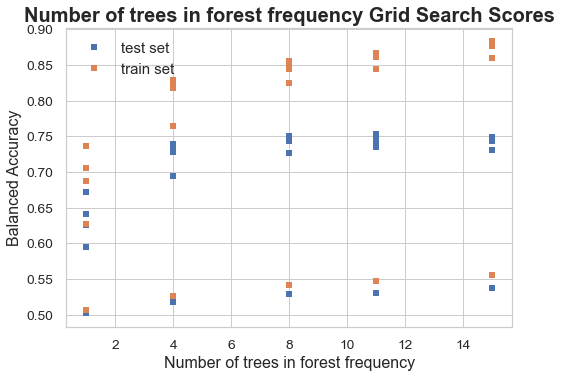

In [11]:
# Plotting the CV results for a gridsearch over one feature

cv_results = tf_rf_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
# Plot one
param = list(rf_parameters.keys())[0]
param_label = "Number of trees in forest frequency"

plot_cv_train_test(cv_results, param, param_label)

In [13]:
tf_rf_grid_searcher.best_params_

{'rf__max_depth': 459.26530612244903}

In [12]:

tf_rf_grid_searcher.cv_results_


{'mean_fit_time': array([0.10342213, 0.18097615, 0.33772186, 0.37950809, 0.5223921 ,
        0.08674261, 0.20788942, 0.3143521 , 0.53290755, 0.67085668,
        0.10451525, 0.24476876, 0.42884251, 0.5513058 , 0.73860587,
        0.10696432, 0.28803304, 0.41309939, 0.5914496 , 0.80979971,
        0.10865818, 0.34316874, 0.45064909, 0.765272  , 0.8558477 ]),
 'std_fit_time': array([0.00958502, 0.01319677, 0.04256907, 0.01291494, 0.06553887,
        0.01256451, 0.02524736, 0.03371574, 0.02404098, 0.0705287 ,
        0.00714227, 0.02036003, 0.02126506, 0.02544003, 0.03630614,
        0.01061937, 0.03868625, 0.02279474, 0.03820837, 0.05760477,
        0.01353349, 0.03182076, 0.0113444 , 0.12638073, 0.08433107]),
 'mean_score_time': array([0.01086913, 0.01760193, 0.03281154, 0.03547553, 0.04797322,
        0.01162396, 0.01938844, 0.02991336, 0.0511321 , 0.05272511,
        0.01223029, 0.02331233, 0.03603336, 0.04471707, 0.05664781,
        0.01347797, 0.02680452, 0.03313065, 0.04129202, 0.05

## Generate predictions using best Random Forest and Count Vectorizer

In [18]:
# count_rf_filename = os.path.join(output_dir, 'bow_count_rf_yproba1_test.txt')
# test_on_estimator(count_rf_grid_searcher.best_estimator_, x_test_text, count_rf_filename)
tf_rf_filename = os.path.join(output_dir, 'bow_tf_rf_yproba1_test.txt')
test_on_estimator(tf_rf_grid_searcher.best_estimator_, x_test_text, tf_rf_filename)


## L1-Logistic Regression: Hyperparameter Search

In [16]:
lasso = sklearn.linear_model.LogisticRegression(penalty='l1', solver='saga', random_state=RANDOM_STATE)
# logit_lasso hyperparameter grid
lasso_parameters = {
     'lasso__C': np.logspace(-3, 3, 7),
     'lasso__max_iter': [20, 40, 60], # sneaky way to do "early stopping" 
}
lasso_pipeline_tuple = ('lasso', lasso)


In [17]:
tf_lasso_pipeline = Pipeline([
    tf_pipeline_tuple,
    lasso_pipeline_tuple,
 ])
tf_lasso_full_grid = { 
#     **count_parameters,
    **lasso_parameters
}


tf_lasso_grid_searcher = GridSearchCV(
    tf_lasso_pipeline, 
    tf_lasso_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_lasso_grid_searcher.fit(x_train_text, y_train)

Fitting 7 folds for each of 21 candidates, totalling 147 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   42.4s
[Parallel(n_jobs=3)]: Done 147 out of 147 | elapsed:  1.7min finished
/Users/dylanphelan/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('lasso',
                                        LogisticRegression(penalty='l1',
                                                           random_state=123,
                                                           solver='saga'))]),
             n_jobs=3,
             param_grid={'lasso__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'lasso__max_iter': [20, 40, 60]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [18]:
print_gridsearch_results(tf_lasso_grid_searcher, list(tf_lasso_full_grid.keys()))

Dataframe has shape: (21, 26)
Number of trials used in grid search:  21


,param_lasso__C,param_lasso__max_iter,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
15,100,20,0.996736,0.805352,2.925054,1
18,1000,20,0.996736,0.805347,3.289313,2
19,1000,40,0.996736,0.804924,6.695363,3
12,10,20,0.994861,0.800764,0.820199,4
20,1000,60,0.997083,0.800332,10.046473,5
16,100,40,0.996736,0.799513,5.011636,6
14,10,60,0.995694,0.797852,1.462644,7
13,10,40,0.995486,0.797437,1.232483,8
17,100,60,0.996736,0.795759,6.406829,9
9,1,20,0.768543,0.748732,0.116262,10


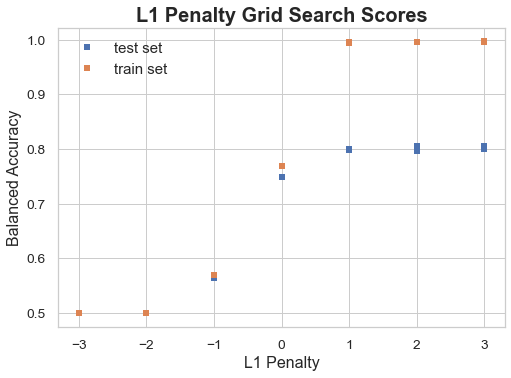

In [19]:
# Plotting the CV results for a gridsearch over one feature

cv_results = tf_lasso_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
# Plot one
param = list(lasso_parameters.keys())[0]
param_label = "L1 Penalty"

plot_cv_train_test(cv_results, param, param_label, log10=True)

In [20]:
tf_lasso_grid_searcher.best_params_

{'lasso__C': 100.0, 'lasso__max_iter': 20}

## L1-Logistic Regression: Generate Predictions

In [25]:
lasso_filename = os.path.join(output_dir, 'bow_count_lasso_yproba1_test.txt')
test_on_estimator(count_lasso_grid_searcher.best_estimator_, x_test_text, lasso_filename)

# Model 3: Gradient Boosted Trees

## Gradient Boosted Tree: Hyperparameter search

**NOTE** Only re-run when necessary. The total run-time for rebuilding these classifiers is roughly 15-30 minutes.

In [29]:
gbtree_classifier = GradientBoostingClassifier(n_estimators=100, max_depth=5, min_samples_leaf=1, random_state=RANDOM_STATE)
# GradientBoosting-Tree hyperparameter grid
gbtree_parameters = {
    "gbtree__n_estimators": [100, 200, 300],
    "gbtree__max_depth": [5, 10, 20],
    "gbtree__min_samples_leaf": [1, 3, 5],
}
gbtree_pipeline_tuple = ('gbtree', gbtree_classifier)


### Fit on the tfidf_vectorizer

In [31]:
tf_gbtree_pipeline = Pipeline([
    tf_pipeline_tuple,
    gbtree_pipeline_tuple,
 ])
tf_gbtree_full_grid = { 
#     **tf_parameters,
    **gbtree_parameters
}


tf_gbtree_grid_searcher = GridSearchCV(
    tf_gbtree_pipeline, 
    tf_gbtree_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_gbtree_grid_searcher.fit(x_train_text, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   10.0s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed:  2.7min
[Parallel(n_jobs=3)]: Done 506 tasks      | elapsed:  6.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 11.6min
[Parallel(n_jobs=3)]: Done 1080 out of 1080 | elapsed: 20.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('gbtree',
                                        GradientBoostingClassifier(max_depth=5,
                                                                   random_state=123))]),
             n_jobs=3,
             param_grid={'gbtree__max_depth': [5, 10, 20],
                         'gbtree__min_samples_leaf': [1, 3, 5],
                         'gbtree__n_estimators': [100, 200, 300],
                         'tf__max_df': (0.05, 0.5), 'tf__min_df': array([1, 2]),
                         'tf__ngram_range': [(1, 1), (1, 2)]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [32]:
print_gridsearch_results(tf_gbtree_grid_searcher, list(tf_gbtree_full_grid.keys()))

Dataframe has shape: (216, 26)
Number of trials used in grid search:  216


,param_tf__min_df,param_tf__max_df,param_tf__ngram_range,param_gbtree__n_estimators,param_gbtree__max_depth,param_gbtree__min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
20,1,0.5,"(1, 1)",300,5,1,0.941979,0.776667,2.447076,1
12,1,0.5,"(1, 1)",200,5,1,0.923750,0.771667,1.560614,2
92,1,0.5,"(1, 1)",300,10,1,0.996146,0.770833,4.124050,3
22,2,0.5,"(1, 1)",300,5,1,0.947604,0.769583,1.807707,4
84,1,0.5,"(1, 1)",200,10,1,0.995937,0.769583,2.854647,5
...,...,...,...,...,...,...,...,...,...,...
27,2,0.05,"(1, 2)",100,5,3,0.819583,0.683333,0.581437,212
209,1,0.05,"(1, 2)",300,20,5,0.940521,0.683333,11.528023,212
48,1,0.05,"(1, 1)",100,5,5,0.797708,0.680833,0.613226,214
211,2,0.05,"(1, 2)",300,20,5,0.940417,0.680417,4.091111,215


In [34]:
tf_gbtree_grid_searcher.best_params_

{'gbtree__max_depth': 5,
 'gbtree__min_samples_leaf': 1,
 'gbtree__n_estimators': 300,
 'tf__max_df': 0.5,
 'tf__min_df': 1,
 'tf__ngram_range': (1, 1)}

## GBTree: Generate Predictions

In [37]:
gbtree_filename = os.path.join(output_dir, 'bow_tf_gbtree_yproba1_test.txt')
test_on_estimator(tf_gbtree_grid_searcher.best_estimator_, x_test_text, gbtree_filename)

In [26]:
# Plotting the CV results for a gridsearch over one feature
cv_results = tf_gbtree_grid_searcher.cv_results_

param = list(gbtree_parameters.keys())[0]
param_label = "Number of esitmators"

plot_cv_train_test(cv_results, param, param_label, log2=True)

NameError: name 'plt' is not defined

# Model 4: MLP Classifier

## MLP Classifier: Hyperparameter Search

In [74]:
mlp = sklearn.neural_network.MLPClassifier(solver='lbfgs', random_state=RANDOM_STATE)
mlp_parameters = {
    'mlp__hidden_layer_sizes': [16, 32, 64],
    'mlp__alpha': [0.0001,0.01,1, 10],
    'mlp__max_iter': [50, 100, 200, 500], # sneaky way to do "early stopping" 
}
mlp_pipeline_tuple = ('mlp', mlp)

In [75]:
tf_mlp_pipeline = Pipeline([
    tf_pipeline_tuple,
    mlp_pipeline_tuple,
 ])
tf_mlp_full_grid = { 
#     **tf_parameters,
    **mlp_parameters
}


tf_mlp_grid_searcher = GridSearchCV(
    tf_mlp_pipeline, 
    tf_mlp_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_mlp_grid_searcher.fit(x_train_text, y_train)

Fitting 7 folds for each of 48 candidates, totalling 336 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   26.2s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 14.9min
[Parallel(n_jobs=3)]: Done 336 out of 336 | elapsed: 19.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('mlp',
                                        MLPClassifier(random_state=123,
                                                      solver='lbfgs'))]),
             n_jobs=3,
             param_grid={'mlp__alpha': [0.0001, 0.01, 1, 10],
                         'mlp__hidden_layer_sizes': [16, 32, 64],
                         'mlp__max_iter': [50, 100, 200, 500]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [76]:
print_gridsearch_results(tf_mlp_grid_searcher, list(tf_mlp_full_grid.keys()))

Dataframe has shape: (48, 27)
Number of trials used in grid search:  48


,param_mlp__hidden_layer_sizes,param_mlp__alpha,param_mlp__max_iter,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
43,32,10,500,0.993472,0.809531,8.508187,1
47,64,10,500,0.993542,0.809116,23.691394,2
40,32,10,50,0.993403,0.809116,5.327484,2
46,64,10,200,0.993542,0.809116,22.770491,2
42,32,10,200,0.993472,0.809113,8.236983,5
41,32,10,100,0.993472,0.809113,6.882638,5
45,64,10,100,0.993472,0.808283,17.188176,7
44,64,10,50,0.993333,0.808280,11.392825,8
37,16,10,100,0.993403,0.807860,3.998769,9
36,16,10,50,0.993403,0.807027,2.700034,10


In [77]:
def plot_cv_train_test(cv_results, param_name, param_label, log10=False, log2=False):
    param_values = cv_results[f'param_{param_name}']
    mean_test_score = cv_results['mean_test_score']
    mean_train_score = cv_results['mean_train_score']

    # Plot Grid search scores
    _, ax = plt.subplots(1, 1)

    x_values = param_values.data.astype(np.float64)
    if (log10):
        x_values = np.log10(x_values)
    elif (log2):
        x_values = np.log2(x_values)
    ax.plot(x_values, mean_test_score, 's', label='test set')
#     ax.plot(x_values, mean_train_score, 's', label='train set')

    ax.set_title(f"{param_label} Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(param_label, fontsize=16)
    ax.set_ylabel('Balanced Accuracy', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

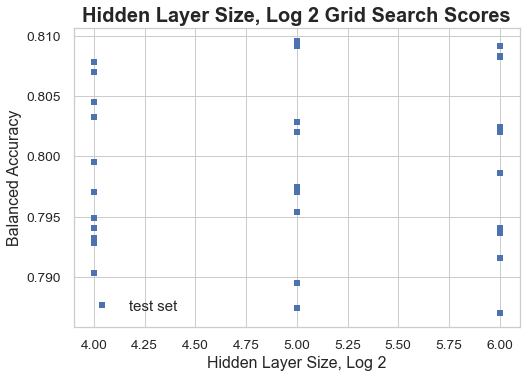

In [78]:
# Plotting the CV results for a gridsearch over one feature
cv_results = tf_mlp_grid_searcher.cv_results_

param = list(mlp_parameters.keys())[0]
param_label = "Hidden Layer Size, Log 2"

plot_cv_train_test(cv_results, param, param_label, log2=True)

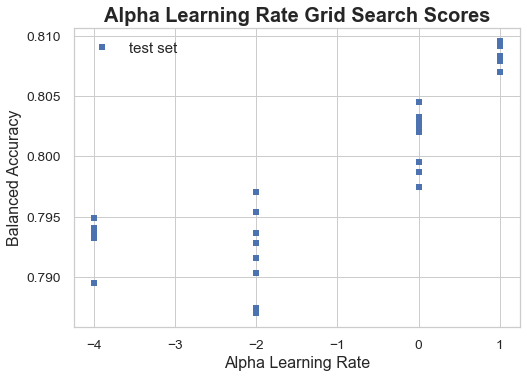

In [79]:
param = list(mlp_parameters.keys())[1]
param_label = "Alpha Learning Rate"

plot_cv_train_test(cv_results, param, param_label, log10=True)

In [80]:
mlp_filename = os.path.join(output_dir, 'bow_tf_mlp_yproba1_test.txt')
test_on_estimator(tf_mlp_grid_searcher.best_estimator_, x_test_text, mlp_filename)

# Archive: Things We May Need 



In [39]:
# np.argwhere(count_rf_grid_searcher.cv_results_["rank_test_score"] == 1)
# count_rf_grid_searcher.cv_results_["mean_train_score"][29]

In [40]:
# random_forest_grid_searcher.fit(x_train_text_count, y_train)

In [41]:
# random_forest_grid_search_results_df = pd.DataFrame(random_forest_grid_searcher.cv_results_).copy()
# n_trials_grid_search = random_forest_grid_search_results_df.shape[0]

In [42]:
# param_keys = ['param_n_estimators', 'param_max_depth']

# # Rearrange row order so it is easy to skim
# random_forest_grid_search_results_df.sort_values(param_keys, inplace=True)
# random_forest_grid_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

### Fit on TFIDF

In [43]:
# random_forest_grid_searcher.fit(x_train_text_tf, y_train)

In [44]:
# random_forest_grid_search_results_df = pd.DataFrame(random_forest_grid_searcher.cv_results_).copy()
# n_trials_grid_search = random_forest_grid_search_results_df.shape[0]

In [45]:
# param_keys = ['param_n_estimators', 'param_max_depth']

# Rearrange row order so it is easy to skim
# random_forest_grid_search_results_df.sort_values(param_keys, inplace=True)
# random_forest_grid_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

In [56]:
# best_random_forest = random_forest_classifier.set_params(**random_forest_grid_searcher.best_params_)
# best_random_forest.fit(x_train_text_count, y_train)

In [47]:
# # Gradient Boosted Tree classifier with default values
# gbtree_classifier = GradientBoostingClassifier(n_estimators=100, max_depth=5, min_samples_leaf=1, random_state=100)

In [48]:
# # Gradient Boosted Tree hyperparameter grid
# gbtree_parameter_grid = dict(
#     n_estimators = [20, 50, 100],
#     max_depth = [5, 10],
#     #min_samples_leaf = [1, 3, 5],
#     #random_state=[101, 202],  # try two possible seeds to initialize parameters
#     random_state=[100],
#     )

In [49]:
# gbtree_grid_searcher = sklearn.model_selection.GridSearchCV(
#     gbtree_classifier,
#     gbtree_parameter_grid,
#     scoring='balanced_accuracy',
#     cv=cv_splitter,
#     return_train_score=True,
#     refit=False)

In [50]:
# gbtree_grid_searcher.fit(x_train_text_count, y_train)

In [51]:
# gbtree_grid_search_results_df = pd.DataFrame(gbtree_grid_searcher.cv_results_).copy()
# n_trials_grid_search = gbtree_grid_search_results_df.shape[0]

In [52]:
# param_keys = ['param_n_estimators', 'param_max_depth']

# # Rearrange row order so it is easy to skim
# gbtree_grid_search_results_df.sort_values(param_keys, inplace=True)

In [53]:
# gbtree_grid_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

In [54]:
# best_gbtree = gbtree_classifier.set_params(**gbtree_grid_searcher.best_params_)
# best_gbtree.fit(x_train_text_count, y_train)

In [63]:
# best_gbtree_yhat_test = best_gbtree.predict(x_test_text_count)
# with open('bow_gbtree_countvectorizer_test_preds.txt', 'w') as f:
#     for pred in best_gbtree_yhat_test:
#         f.write(str(pred) + '\n')

In [64]:
# lasso = sklearn.linear_model.LogisticRegression(
#     penalty='l1', solver='saga', random_state=101)

In [65]:
# lasso_hyperparameter_grid_by_name = dict(
#     C=np.logspace(-4, 4, 9),
#     max_iter=[20, 40], # sneaky way to do "early stopping" 
#                        # we'll take either iter 20 or iter 40 in training process, by best valid performance
#     )

In [66]:
# lasso_searcher = sklearn.model_selection.GridSearchCV(
#     lasso,
#     lasso_hyperparameter_grid_by_name,
#     scoring='balanced_accuracy',
#     cv=cv_splitter,
#     return_train_score=True,
#     refit=False)

In [67]:
# lasso_searcher.fit(x_train_text_count, y_train)

In [68]:
# lasso_search_results_df = pd.DataFrame(lasso_searcher.cv_results_).copy()

In [69]:
# param_keys = ['param_C', 'param_max_iter']

# # Rearrange row order so it is easy to skim
# lasso_search_results_df.sort_values(param_keys, inplace=True)

In [70]:
# lasso_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

In [71]:
# best_lasso = lasso.set_params(**lasso_searcher.best_params_)
# best_lasso.fit(x_train_text_count, y_train)

In [72]:
# best_lasso_yhat_test = best_lasso.predict_proba(x_test_text_count)[:,1]
# np.savetxt('yproba1_test.txt', best_lasso_yhat_test)

### RF: Fit on CountVector

In [40]:
count_rf_pipeline = Pipeline([
    count_pipeline_tuple,
    rf_pipeline_tuple,
 ])
count_rf_full_grid = { 
#     **count_parameters,
    **rf_parameters
}


count_rf_grid_searcher = GridSearchCV(
    count_rf_pipeline, 
    count_rf_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    return_train_score=True,
    scoring='balanced_accuracy'
)
count_rf_grid_searcher.fit(x_train_text, y_train)

Fitting 7 folds for each of 25 candidates, totalling 175 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   14.3s


KeyboardInterrupt: 

In [15]:
print_gridsearch_results(count_rf_grid_searcher, list(count_rf_full_grid.keys()))

Dataframe has shape: (50, 25)
Number of trials used in grid search:  50


,param_rf__max_depth,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
10,102.837,0.918541,0.775046,0.934253,1
6,62.102,0.907567,0.773368,0.666190,2
8,82.4694,0.915276,0.773365,0.792648,3
4,41.7347,0.898679,0.773363,0.617309,4
9,92.6531,0.916874,0.771714,0.856381,5
5,51.9184,0.902707,0.771692,0.668766,6
11,113.02,0.922429,0.769212,0.978202,7
7,72.2857,0.911109,0.768758,0.728714,8
49,500,0.997153,0.768744,1.807710,9
48,489.816,0.997153,0.767493,1.821891,10


In [ ]:
cv_results = count_rf_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
# Plot one
param = list(rf_parameters.keys())[0]
param_label = "Max Depth of trees"

plot_cv_single_param(cv_results, param, param_label)


In [17]:
count_rf_grid_searcher.best_params_

{'rf__max_depth': 102.83673469387756}